<h1>3- Feature Engineering and Modeling</h1>

<p align="justify" style="border: 1px solid black; padding: 10px; border-radius: 5px;">First part of this notebook serves as the third stage in our data analysis pipeline, building upon the cleaned and preprocessed data from the "member", "transactions", and "user logs" tables. The focus here is on feature engineering to create new variables that can better inform our predictive models. Techniques such as binning, normalization, and creating interaction terms are employed. This ensures that the data is clean and optimized for machine learning algorithms.</p>

In [1]:
# Dependencies and Setup
import package as pk

Package: Resources loaded. ☑


<h2>1-3- Import Data from BigQuery Tables into Spark DataFrames</h2>

In [2]:
# Instantiate the 'DataToSpark' class to handle KKBOX data
kkbox = pk.DataToSpark("customer-churn-391917", "kkbox")

# Load specific tables into DataFrames
tables_to_load = ["member_model_main","city_model_main"]
kkbox.load_tables(tables_to_load)

# Retrieve the stored DataFrames
table = kkbox.get_tables()

In [3]:
# Create an instance of the class with each dataframe
member_model_df = table["member_model_main"]
city_model_df = table["city_model_main"]

<h2>2-3- Feature Engineering</h2>

In [4]:
def feature_maker(df):
    """
    Engineer new features in the given PySpark DataFrame.
    
    Parameters:
    df (DataFrame): The input PySpark DataFrame.
    
    Returns:
    DataFrame: The DataFrame with new features added.
    """
    
    # Add a 'refund' column: 1 if 'membership_expire_date' is before 'transaction_date', otherwise 0
    df = df.withColumn(
        "refund",
        pk.when(pk.col('membership_expire_date') < pk.col('transaction_date'), 1).otherwise(0)
    )
    
    # Add a 'suspicious' column: 1 if the difference between 'transaction_date' and 'exp_last' is greater than 31, otherwise 0
    df = df.withColumn(
        "suspicious",
        pk.when((pk.col('transaction_date') - pk.col('exp_last')) > 31, 1).otherwise(0)
    )
    
    # Add a 'discount' column: 1 if 'plan_list_price' is greater than 'actual_amount_paid', otherwise 0
    df = df.withColumn(
        "discount",
        pk.when((pk.col('plan_list_price') - pk.col('actual_amount_paid')) > 0, 1).otherwise(0)
    )
    
    # Calculate daily price based on plan and actual amount paid
    df = df.withColumn("daily_price_plan", pk.col("plan_list_price") / pk.col("payment_plan_days"))
    df = df.withColumn("daily_price_act", pk.col("actual_amount_paid") / pk.col("payment_plan_days"))
    
    # Calculate inactivity and other aggregated features
    df = df.withColumn("inactivity", 31 - pk.col("activity_count"))
    df = df.withColumn('total', pk.col('sum_num_25') + pk.col('sum_num_50') + pk.col('sum_num_75') + pk.col('sum_num_985') + pk.col('sum_num_100'))
    df = df.withColumn('percent_100', pk.round(pk.col('sum_num_100') / pk.col('total'), 2))
    df = df.withColumn('percent_unique', pk.round(pk.col('sum_num_unq') / pk.col('total'), 2))
    df = df.withColumn('seconds_per_song', pk.round(pk.col('total_secs') / pk.col('total'), 2))
    df = df.withColumn('spend_time_perday', pk.round(pk.col('total_secs') / pk.col('activity_count'), 2))
    df = df.withColumn('spend_unique_perday', pk.round(pk.col('sum_num_unq') / pk.col('activity_count'), 2))
    df = df.withColumn('spend_num_100_perday', pk.round(pk.col('sum_num_100') / pk.col('activity_count'), 2))
    
    # Add a 'day_of_the_week' column based on 'transaction_date'
    df = df.withColumn("day_of_the_week", pk.date_format("transaction_date", "EEEE"))
    
    # Convert 'day_of_the_week' to binary: 1 for weekends and 0 for weekdays
    df = df.withColumn(
        "day_of_the_week",
        pk.when((pk.col("day_of_the_week") == "Sunday") | (pk.col("day_of_the_week") == "Saturday"), 1).otherwise(0)
    )
    
    # Add a 'registration_year' column based on 'registration_init_time'
    df = df.withColumn("registration_year", pk.year(pk.col("registration_init_time")))
    
    # Round 'total_secs' to 2 decimal places
    df = df.withColumn("total_secs", pk.round(pk.col("total_secs"), 2))
    
    # Drop unnecessary columns
    df = df.drop("registration_init_time", "transaction_date", "membership_expire_date", "exp_last", "is_cancel", "is_auto_renew")
    
    # Convert categorical columns to integer type
    categorical_columns = ["city", "bd", "gender", "registered_via", "activity_count"]
    for column in categorical_columns:
        df = df.withColumn(column, pk.col(column).cast("int"))
        
    return df


In [5]:
# Call the feature_maker function with "member_model_df" DataFrame
member_model_data = feature_maker(member_model_df)

In [6]:
# Call the feature_maker function with "city_model_df" DataFrame
city_model_data = feature_maker(city_model_df)

<h3>1-2-3- Split Data</h3>

In [7]:
# Call the data_spliter function for "member_model_data"
member_train_model, member_test_model = pk.data_spliter(member_model_data, train_ratio=0.8, seed=42)

23/09/11 17:49:03 WARN org.apache.spark.util.Utils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.debug.maxToStringFields' in SparkEnv.conf.
[Stage 2:>                                                          (0 + 2) / 2]

Number of records
 |-- Train: 312894
 |-- Test: 77779


In [8]:
# Call the data_spliter function for "city_model_data"
city_train_model, city_test_model = pk.data_spliter(city_model_data, train_ratio=0.8, seed=42)

[Stage 6:>                                                          (0 + 2) / 2]

Number of records
 |-- Train: 295226
 |-- Test: 73260


<h2>3-3- Modeling</h2>

<p align="justify" style="border: 1px solid black; padding: 10px; border-radius: 5px;">This notebook represents the final stage in our data analysis pipeline, leveraging the cleaned and feature-engineered data to build predictive models. Various machine learning algorithms like Logistic Regression, Decision Trees, and Random Forests are explored to identify the model that best predicts customer churn. The notebook includes steps for model training, hyperparameter tuning, and evaluation using metrics such as accuracy, precision, and recall. This culminates our end-to-end data science workflow, from data cleaning to predictive modeling.</p>

In [9]:
# Define the target column for the churn prediction model
target_col = 'is_churn'

<h3>1-3-3- Member Dataset</h3>

In [10]:
# drop "msno" column
member_train_model=member_train_model.drop("msno")

In [11]:
# Create a list of feature columns by excluding the target column from the DataFrame's columns
member_features_fitted = [col for col in member_train_model.columns if col != target_col]

# Initialize a VectorAssembler to combine feature columns into a single feature vector
# The handleInvalid parameter is set to "keep" to handle any invalid data during transformation
member_assembler = pk.VectorAssembler(inputCols=member_features_fitted, outputCol="features", handleInvalid="keep")

# Initialize a StringIndexer to convert the categorical target column to a numerical label
member_indexer = pk.StringIndexer(inputCol=target_col, outputCol="label")

# Create an instance of ModelSelector, a custom class for model selection
# The class is assumed to handle model fitting and evaluation
member_model_selector = pk.ModelSelector(member_train_model, member_test_model, member_assembler, member_indexer)

# Fit the models using the training data and evaluate them using the test data
member_model_selector.fit()

# Display the evaluation results, such as accuracy, precision, and recall for each model
member_model_selector.display_results()

[Stage 2396:>                                                       (0 + 2) / 2]23/09/11 18:04:11 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
23/09/11 18:04:11 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS
23/09/11 18:23:13 ERROR breeze.optimize.OWLQN: Failure! Resetting history: breeze.optimize.NaNHistory: 
23/09/11 18:23:31 ERROR breeze.optimize.OWLQN: Failure! Resetting history: breeze.optimize.NaNHistory: 
23/09/11 18:23:47 ERROR breeze.optimize.OWLQN: Failure! Resetting history: breeze.optimize.NaNHistory: 
23/09/11 18:28:22 ERROR breeze.optimize.OWLQN: Failure! Resetting history: breeze.optimize.NaNHistory: 
23/09/11 18:28:40 ERROR breeze.optimize.OWLQN: Failure! Resetting history: breeze.optimize.NaNHistory: 
23/09/11 18:28:57 ERROR breeze.optimize.OWLQN: Failure! Resetting history: breeze.optimize.NaNHistory: 
23/09/11 18:33:37 ERROR breeze.opti

Best model: Gradient-Boosted Tree with F1 score: 0.9134717310364813


+--------------------+------------------+------------------+------------------+------------------+------------------+
|               Model|          Accuracy|         Precision|            Recall|          F1 Score|               AUC|
+--------------------+------------------+------------------+------------------+------------------+------------------+
|       Decision Tree|   0.9272811427249|0.9106111128539576|   0.9272811427249|0.9120748620804312|0.3553747841982733|
|       Random Forest|  0.92676686509212|0.9087469142422727|0.9267668650921199|0.9077972270718955| 0.820598167751489|
|Gradient-Boosted ...|0.9288625464456987|0.9133015637194454|0.9288625464456988|0.9134717310364813|0.8510768147900649|
|Linear Support Ve...|0.9218683706398899|0.9168124701294946|0.9218683706398899|0.8844801634372277|0.5000069737924878|
+--------------------+------------------+------------------+------------------+------------------+------------------+



In [13]:
# Storing the best model from the model selector into 'member_model_fitted'
member_model_fitted = member_model_selector.best_model

<ul><li><b>Feature Importance</b></li></ul>

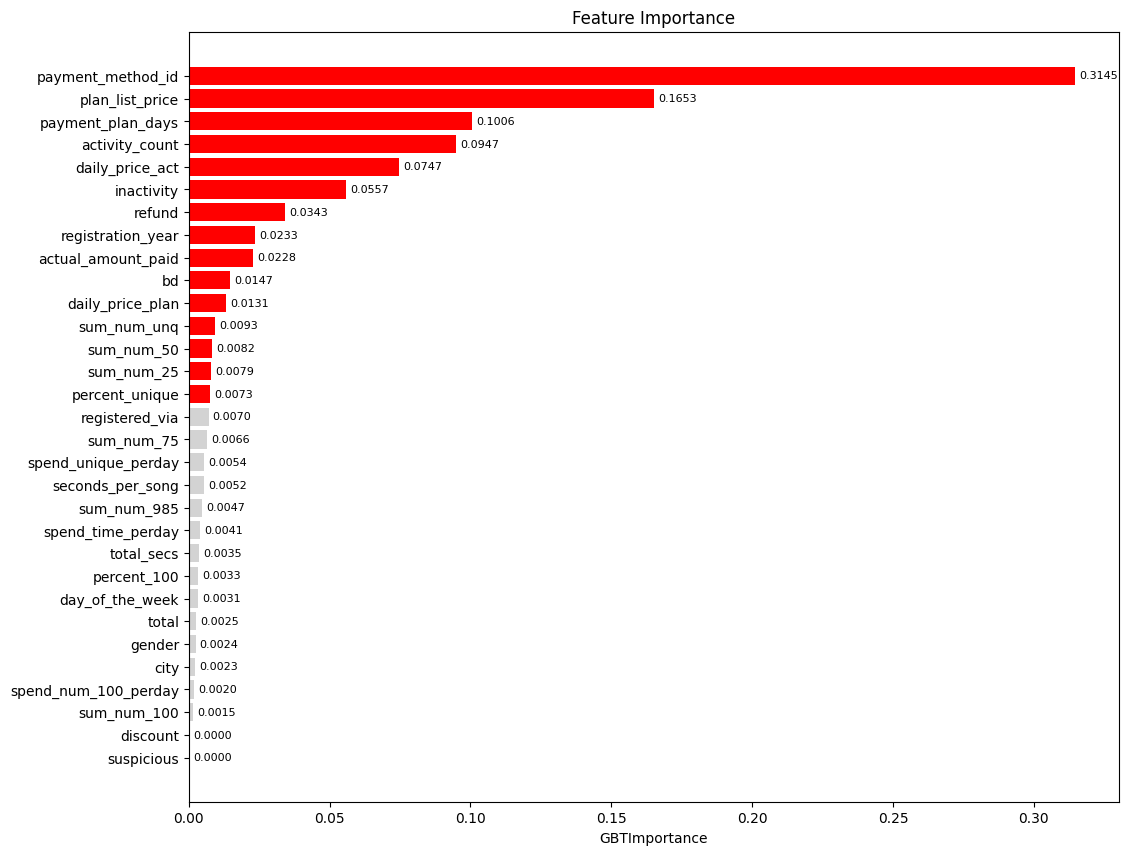

In [52]:
# Extracting feature importance from the Gradient Boosted Trees model
member_feature_importance=extract_gbt_feature_importance(member_model_fitted, member_features_fitted)

<ul><li><b>Validation</b></li></ul>

In [17]:
pk.calculate_predictions_and_accuracy(member_model_fitted, member_test_model, member_features_fitted, key_col = "msno" , target_col = 'is_churn')

(DataFrame[msno: string, city: int, bd: int, gender: int, registered_via: int, payment_method_id: bigint, payment_plan_days: bigint, plan_list_price: bigint, actual_amount_paid: bigint, activity_count: int, sum_num_25: bigint, sum_num_50: bigint, sum_num_75: bigint, sum_num_985: bigint, sum_num_100: bigint, sum_num_unq: bigint, total_secs: double, refund: int, suspicious: int, discount: int, daily_price_plan: double, daily_price_act: double, inactivity: double, total: bigint, percent_100: double, percent_unique: double, seconds_per_song: double, spend_time_perday: double, spend_unique_perday: double, spend_num_100_perday: double, day_of_the_week: int, registration_year: int, features: vector, rawPrediction: vector, probability: vector, prediction: double, prob_1: float, is_churn: bigint],
 0.929,
 0.8510768147900648)

<h3>2-3-3- City Dataset</h3>

In [18]:
# drop "msno" and "city" columns
city_train_model=city_train_model.drop("msno", "city")

In [19]:
# Create a list of feature columns by excluding the target column from the DataFrame's columns
city_features_fitted = [col for col in city_train_model.columns if col != target_col]

# Initialize a VectorAssembler to combine feature columns into a single feature vector
# The handleInvalid parameter is set to "keep" to handle any invalid data during transformation
city_assembler = pk.VectorAssembler(inputCols=city_features_fitted, outputCol="features", handleInvalid="keep")

# Initialize a StringIndexer to convert the categorical target column to a numerical label
city_indexer = pk.StringIndexer(inputCol=target_col, outputCol="label")

# Create an instance of ModelSelector, a custom class for model selection
# The class is assumed to handle model fitting and evaluation
city_model_selector = pk.ModelSelector(city_train_model, city_test_model, city_assembler, city_indexer)

# Fit the models using the training data and evaluate them using the test data
city_model_selector.fit()

# Display the evaluation results, such as accuracy, precision, and recall for each model
city_model_selector.display_results()

23/09/11 23:25:31 ERROR breeze.optimize.OWLQN: Failure! Resetting history: breeze.optimize.NaNHistory: 
23/09/11 23:26:14 ERROR breeze.optimize.OWLQN: Failure! Resetting history: breeze.optimize.NaNHistory: 
23/09/11 23:32:17 ERROR breeze.optimize.OWLQN: Failure! Resetting history: breeze.optimize.NaNHistory: 
23/09/11 23:33:07 ERROR breeze.optimize.OWLQN: Failure! Resetting history: breeze.optimize.NaNHistory: 
23/09/11 23:39:43 ERROR breeze.optimize.OWLQN: Failure! Resetting history: breeze.optimize.NaNHistory: 
23/09/11 23:40:26 ERROR breeze.optimize.OWLQN: Failure! Resetting history: breeze.optimize.NaNHistory: 
23/09/11 23:46:03 ERROR breeze.optimize.OWLQN: Failure! Resetting history: breeze.optimize.NaNHistory: 
23/09/11 23:46:41 ERROR breeze.optimize.OWLQN: Failure! Resetting history: breeze.optimize.NaNHistory: 
23/09/11 23:52:17 ERROR breeze.optimize.OWLQN: Failure! Resetting history: breeze.optimize.NaNHistory: 
23/09/11 23:52:56 ERROR breeze.optimize.OWLQN: Failure! Resettin

Best model: Gradient-Boosted Tree with F1 score: 0.9450852341054083
+--------------------+------------------+------------------+------------------+------------------+------------------+
|               Model|          Accuracy|         Precision|            Recall|          F1 Score|               AUC|
+--------------------+------------------+------------------+------------------+------------------+------------------+
|       Decision Tree|0.9577941577941578|0.9451969324382521|0.9577941577941578|0.9424607823103551|0.2364397750233841|
|       Random Forest|0.9573846573846574|0.9447059504312778|0.9573846573846574| 0.940232163570972|0.8093021920669614|
|Gradient-Boosted ...|0.9580535080535081|0.9455374434767226| 0.958053508053508|0.9450852341054083| 0.828028607730925|
|Linear Support Ve...|0.9567158067158067|0.9461631859130559|0.9567158067158067|0.9366757141519103|0.6417136945147941|
+--------------------+------------------+------------------+------------------+------------------+--------

In [21]:
# Storing the best model from the model selector into 'city_model_fitted'
city_model_fitted = city_model_selector.best_model

<ul><li><b>Feature Importance</b></li></ul>

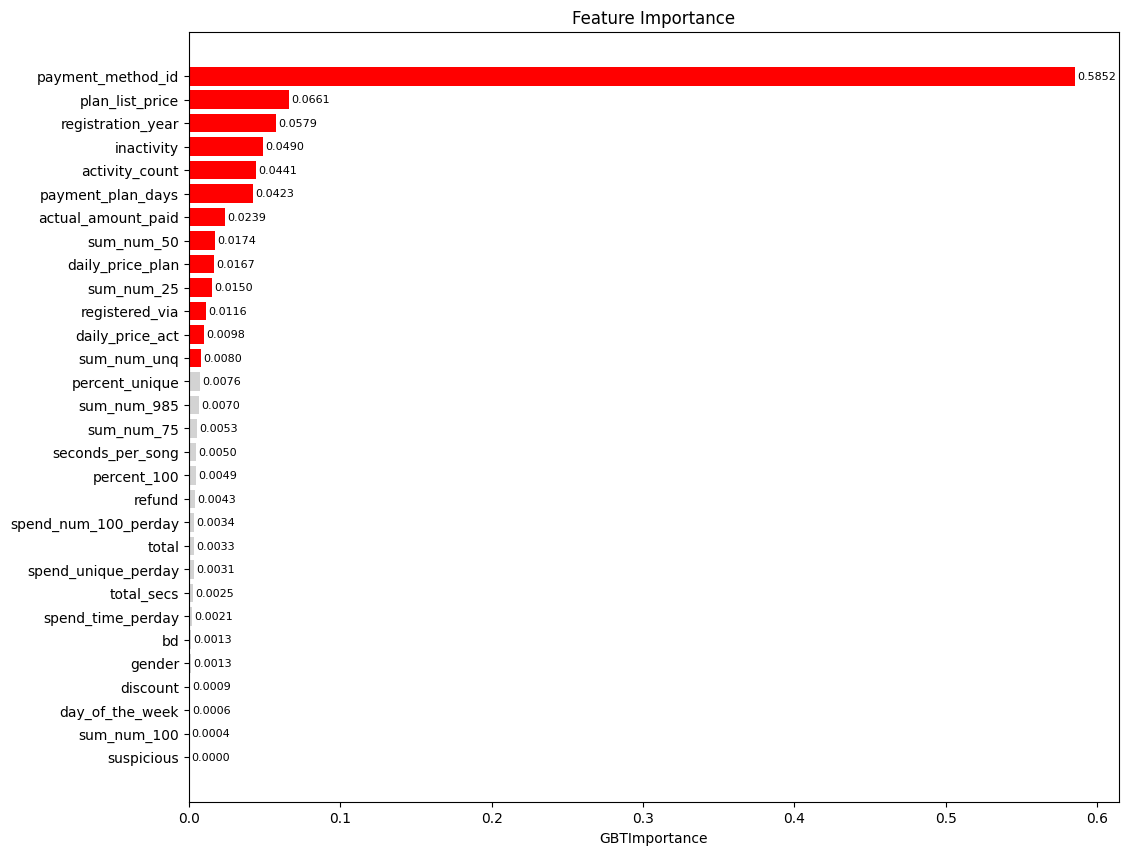

In [51]:
# Extracting feature importance from the Gradient Boosted Trees model
city_feature_importance=extract_gbt_feature_importance(city_model_fitted, city_features_fitted)

<ul><li><b>Validation</b></li></ul>

In [23]:
pk.calculate_predictions_and_accuracy(city_model_fitted, city_test_model, city_features_fitted, key_col = "msno" , target_col = 'is_churn')

(DataFrame[msno: string, bd: int, gender: int, registered_via: int, payment_method_id: bigint, payment_plan_days: bigint, plan_list_price: bigint, actual_amount_paid: bigint, activity_count: int, sum_num_25: bigint, sum_num_50: bigint, sum_num_75: bigint, sum_num_985: bigint, sum_num_100: bigint, sum_num_unq: bigint, total_secs: double, refund: int, suspicious: int, discount: int, daily_price_plan: double, daily_price_act: double, inactivity: double, total: bigint, percent_100: double, percent_unique: double, seconds_per_song: double, spend_time_perday: double, spend_unique_perday: double, spend_num_100_perday: double, day_of_the_week: int, registration_year: int, features: vector, rawPrediction: vector, probability: vector, prediction: double, prob_1: float, is_churn: bigint],
 0.958,
 0.8280286077309251)